# Starbucks Offers EDA

In [54]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [71]:
portfolio_df = pd.read_json('../data/portfolio.json', orient='records', lines=True)
profile_df = pd.read_json('../data/profile.json', orient='records', lines=True)
transcript_df = pd.read_json('../data/transcript.json', orient='records', lines=True)

analises
- Quantidade de clientes que receberam alguma campanha
- Percentual de valor por faixa de dias que são por efeito de campanhas ou não
- Quantidade de transações por faixa de dias que são por efeito de campanhas ou não
- Porcentagem de valor por faixa de dias e por tipo de oferta
- Porcentagem de spending por safra de cliente e faixa de renda

In [72]:
portfolio_df.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [73]:
profile_df.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [74]:
transcript_df.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [75]:
offers_delivered_df = transcript_df[transcript_df.event != 'transaction'].copy()

offers_delivered_df['offer_id'] = offers_delivered_df['value'].apply(
    lambda x: x.get('offer id') if x.get('offer id') is not None else x.get('offer_id')
)

offers_delivered_df['event'] = offers_delivered_df['event'].replace(' ', '_', regex=True)

offers_delivered_df = offers_delivered_df.merge(
    portfolio_df, 
    left_on='offer_id', 
    right_on='id', 
    how='left'
)

offers_delivered_df['offer_type_event'] = \
    offers_delivered_df['offer_type'] + '_' + offers_delivered_df['event']

offers_delivered_df['expiration'] = \
    offers_delivered_df['time'] + offers_delivered_df['duration']

In [76]:
grouped_df = offers_delivered_df.groupby(['offer_type', 'event']).person.count().reset_index()
pivot_df = grouped_df.pivot(index='offer_type', columns='event', values='person')\
    .fillna(0).astype(int).reset_index()
pivot_df = pivot_df[['offer_type', 'offer_received', 'offer_viewed', 'offer_completed']]

pivot_df['view_rate'] = (pivot_df.offer_viewed/pivot_df.offer_received).round(2)
pivot_df['conversion_rate'] = (pivot_df.offer_completed/pivot_df.offer_viewed).round(2)
pivot_df['completion_rate'] = (pivot_df.offer_completed/pivot_df.offer_received).round(2)
pivot_df

event,offer_type,offer_received,offer_viewed,offer_completed,view_rate,conversion_rate,completion_rate
0,bogo,30499,25449,15669,0.83,0.62,0.51
1,discount,30543,21445,17910,0.70,0.84,0.59
2,informational,15235,10831,0,0.71,0.00,0.00


In [77]:
transactions_df = transcript_df[transcript_df.event == 'transaction'].copy()
transactions_df['amount'] = transactions_df['value'].apply(
    lambda x: x.get('amount')
)

transactions_df = transactions_df.rename(columns={'time':'transaction_time'})

transactions_df = transactions_df.groupby(['person', 'transaction_time'])\
    .amount.sum().reset_index()

transactions_df.head()

,person,transaction_time,amount
0,0009655768c64bdeb2e877511632db8f,228,22.16
1,0009655768c64bdeb2e877511632db8f,414,8.57
2,0009655768c64bdeb2e877511632db8f,528,14.11
3,0009655768c64bdeb2e877511632db8f,552,13.56
4,0009655768c64bdeb2e877511632db8f,576,10.27


In [78]:
transactions_df.shape

(138953, 3)

In [79]:
offer_viewed_df.shape

(57725, 13)

In [81]:
offer_viewed_df = offers_delivered_df[offers_delivered_df.event == 'offer_viewed']
amount_per_offer_df = offer_viewed_df.merge(transactions_df, on='person')

amount_per_offer_df = amount_per_offer_df[
    (amount_per_offer_df.transaction_time >= amount_per_offer_df.time) &
    (amount_per_offer_df.transaction_time <= amount_per_offer_df.expiration)
]

amount_per_offer_df = amount_per_offer_df\
    .groupby(['person', 'offer_type', 'transaction_time']).amount.sum()\
        .reset_index()

amount_per_offer_df.head()

,person,offer_type,transaction_time,amount
0,00426fe3ffde4c6b9cb9ad6d077a13ea,discount,192,0.97
1,00426fe3ffde4c6b9cb9ad6d077a13ea,informational,36,5.33
2,005500a7188546ff8a767329a2f7c76a,bogo,582,9.03
3,0091d2b6a5ea4defaa8393e4e816db60,bogo,6,18.26
4,0091d2b6a5ea4defaa8393e4e816db60,bogo,408,27.32


In [82]:
amount_per_offer_df.offer_type.value_counts()

discount         5195
bogo             4634
informational    1255
Name: offer_type, dtype: int64

In [102]:
transactions_df['offer_type'] = 'no_offer'
all_transactions_df = pd.concat([amount_per_offer_df, transactions_df])

In [103]:
all_transactions_df = all_transactions_df.drop_duplicates(
  subset = ['person', 'transaction_time', 'amount'],
  keep = 'first').reset_index(drop = True)

In [97]:
all_transactions_df.offer_type.value_counts()

no_offer         127872
discount           5194
bogo               4634
informational      1255
Name: offer_type, dtype: int64

In [104]:
all_transactions_df.duplicated().sum()

0

<AxesSubplot:xlabel='offer_type', ylabel='amount'>

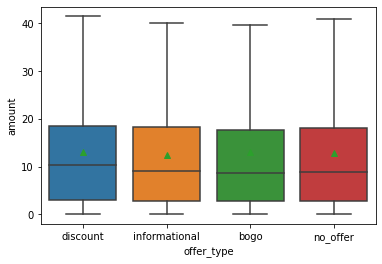

In [109]:
sns.boxplot(
    data=all_transactions_df, 
    x="offer_type", y="amount", showfliers=False, showmeans=True)

In [116]:
grouped_df = all_transactions_df.groupby("offer_type")\
    .agg({"amount": [np.mean, np.min, np.median, np.max]})\
        .round(2).reset_index()

grouped_df.columns = grouped_df.columns.droplevel()
grouped_df.sort_values(by='median', ascending=False)

,,mean,amin,median,amax
1,discount,13.04,0.05,10.38,989.34
2,informational,12.36,0.05,9.05,552.43
3,no_offer,12.76,0.05,8.83,1062.28
0,bogo,13.00,0.05,8.61,871.51


In [119]:
all_transactions_df['is_offer'] = (all_transactions_df.offer_type != 'no_offer')*1

In [128]:
grouped_df = all_transactions_df.groupby(['person', 'is_offer']).amount.mean().reset_index()
pivot_df = grouped_df.pivot(index='person', columns='is_offer', values='amount').fillna(0).round(2).reset_index()
pivot_df['tpv_offer'] = (pivot_df[1] > pivot_df[0])*1

In [129]:
pivot_df.tpv_offer.value_counts()

0    13254
1     3324
Name: tpv_offer, dtype: int64